In [1]:
library(MASS)
library(tidyverse)

suppressPackageStartupMessages({
    library(gdata)
    library(singlecellmethods)
    library(matrixStats)
    library(data.table)
    library(viridis)
    # library(seaborn)
    library(RColorBrewer)
    library(pheatmap)
    library(Matrix)
    library(harmony)
    library(uwot)
    library(irlba)
    # library(Seurat)
    # library(factoextra)
})


source('../../../GSK/Github/minecraft-seq/scripts/utils.R') #extra functions 
source('../../../GSK/Github/minecraft-seq/scripts/misc_funcs.R') #extra functions #2

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.5.1     ✔ purrr   1.0.2
✔ tibble  3.2.1     ✔ dplyr   1.1.0
✔ tidyr   1.3.1     ✔ stringr 1.5.1
✔ readr   2.1.2     ✔ forcats 0.5.1

Warning message:
“package ‘readr’ was built under R version 4.1.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::select() masks MASS::select()

Warning message:
“package ‘RColorBrewer’ was built under R version 4.1.3”
Warning message:
“package ‘Rcpp’ was built under R version 4.1.2”

Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract



Attaching package: ‘patchwork’


The following object is masked from ‘package:MASS’:

    area




In [2]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /data/srlab1/mcurtis/miniforge3/envs/R4.1.1Py3.9.7/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] dendsort_0.3.4          patchwork_1.3.0         magrittr_2.0.3         
 [4] irlba_2.3.5             uwot_0.2.2              harmony_0.1.0          
 [7] Rcpp_1.0.8.3            Matrix_1.4-1            pheatmap_1.0.12        
[10] RColorBrewer_1.1-3      viridis_0.6.5           vi

# Load data

In [3]:
getwd()

[1] "/data/srlab1/mcurtis/GSK/Experiments/Analysis"

In [3]:
name='CD45'

data_dir = '../CD45_Data_Analysis/'

In [10]:
dna_fn = '../Misc/CD45UpdatedGenotypes_20250129.csv'

In [4]:
rna_counts_fn = paste0(data_dir, 'exprs.mtx')
rna_barcodes_fn = paste0(data_dir, 'exprs_colnames.csv')
rna_features_fn = paste0(data_dir, 'exprs_rownames.csv')

adt_counts_fn = paste0(data_dir, 'counts_ADT_filt.mtx')
adt_barcodes_fn = paste0(data_dir, 'colnames_counts_ADT_filt.csv')
adt_features_fn = paste0(data_dir, 'rownames_counts_ADT_filt.csv')

filt_meta_fn = paste0(data_dir, 'filt_meta.csv')
flow_matrix_fn = paste0(data_dir, 'CD45Plots.csv')

In [5]:
rna_counts = readMM(rna_counts_fn)
rna_features = read_delim(rna_features_fn, ',', col_names = c('index', 'feature'), skip = 1)[['feature']]
rna_barcodes = read_delim(rna_barcodes_fn, ',', col_names = c('index', 'cell'), skip = 1)[['cell']]

rownames(rna_counts) = rna_features
colnames(rna_counts) = rna_barcodes

Rows: 36591 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): feature
dbl (1): index

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 6144 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): cell
dbl (1): index

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
adt_counts = readMM(adt_counts_fn)
adt_features = read_delim(adt_features_fn, ',', col_names = c('index', 'feature'), skip = 1)[['feature']]
adt_barcodes = read_delim(adt_barcodes_fn, ',', col_names = c('index', 'cell'), skip = 1)[['cell']]

rownames(adt_counts) = adt_features
colnames(adt_counts) = adt_barcodes

Rows: 154 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): feature
dbl (1): index

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 6144 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): cell
dbl (1): index

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [29]:
filt_meta = read_delim(filt_meta_fn, ',')
flow_matrix = read_delim(flow_matrix_fn, ',')
geno = read_delim(dna_fn) %>% as.data.frame
rownames(geno) = geno$cell

In [8]:
filt_meta %>% dim
flow_matrix %>% dim
length(intersect(flow_matrix[['cell']], filt_meta[filt_meta['Condition']==name, ][['cell']]))

[1] 3267   13

[1] 628  32

[1] 628

In [9]:
meta_full = flow_matrix
meta_full = meta_full %>% as.data.frame
rownames(meta_full) = meta_full$cell

# Remove NAs
meta_full = meta_full[meta_full['Edited_Index'] %>% drop_na() %>% rownames, ]

rna_counts_filt = rna_counts[, meta_full[['cell']]]
adt_counts_filt = adt_counts[, meta_full[['cell']]]

In [12]:
rna_counts_filt %>% dim
adt_counts_filt %>% dim

[1] 36591   624

[1] 154 624

In [13]:
meta_full %>% dim
meta_full %>% head(2)

[1] 624  32

,DNA_Barcode,Well_ID,Alleles,Reference,genotype,PlateLabel,Condition,RNA_Barcode,ADT_Barcode,RNA_cell,⋯,APC_CD81,APCCY7_CD45,Individual_Index,Edited_Index,CD45KO_Index,genotype_count,nUMI.x,nGenes.x,nUMI.y,nGenes.y
,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AACATCTCTGTGAC_CCGCATATTC,CGGCAATGGA,A1,TTTTTTGGTTAAGGAAAAGGTTGGAAAAGGCCTTGGCCAACCAATTTTAAAAGGGGAAGGTTAAAATTTTAACCCCTTGG,TTTTTTGGTTAAGGAAAAGGTTGGAAAAGGCCTTGGCCAACCAATTCCAAAAGGGGAAGGTTAAAATTTTAACCCCTTGG,1,CD45_P3,CD45,CCGCATATTC,CCTTGTTAAT,AACATCTCTGTGAC,⋯,1.000000,53.51994,10020543,Edited,KO,165,13682,147,20034,2774
AAGCTCCACTCAGA_CCGCATATTC,CGGCAATGGA,A10,TTTTTTGGTTAAGGAAAAGGTTGGAAAAGGCCTTGGCCAACCAATTCCAAAAGGGGAAGGTTAAAATTTTAACCCCTTGG,TTTTTTGGTTAAGGAAAAGGTTGGAAAAGGCCTTGGCCAACCAATTCCAAAAGGGGAAGGTTAAAATTTTAACCCCTTGG,2,CD45_P3,CD45,CCGCATATTC,CCTTGTTAAT,AAGCTCCACTCAGA,⋯,3.854229,20.81418,10038222,Edited,WT,387,3975,128,3036,1150


In [33]:
# meta_full = meta_full %>% mutate(Dosage = 
#                             ifelse(genotype == 2, 0, ifelse( genotype == 1, 2, ifelse(genotype == 3, 1 , NA)))) 

# meta_full = meta_full %>% mutate(HomoRef_v_Other = ifelse(Dosage == 0, 'Control', 
#                                   ifelse( Dosage == 1, 'Het/Homo Alt', ifelse(Dosage == 2, 'Het/Homo Alt', NA)))) 

# meta_full = meta_full %>% mutate(HomoAlt_v_Other = ifelse(Dosage == 0, 'Control', 
#                                   ifelse( Dosage == 1, 'Control', ifelse(Dosage == 2, 'Homo Alt', NA)))) 

In [34]:
meta_full

,DNA_Barcode,Well_ID,Alleles,Reference,genotype,PlateLabel,Condition,RNA_Barcode,ADT_Barcode,RNA_cell,⋯,APCCY7_CD45,Individual_Index,Edited_Index,CD45KO_Index,genotype_count,nUMI.x,nGenes.x,nUMI.y,nGenes.y,Dosage
,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AACATCTCTGTGAC_CCGCATATTC,CGGCAATGGA,A1,TTTTTTGGTTAAGGAAAAGGTTGGAAAAGGCCTTGGCCAACCAATTTTAAAAGGGGAAGGTTAAAATTTTAACCCCTTGG,TTTTTTGGTTAAGGAAAAGGTTGGAAAAGGCCTTGGCCAACCAATTCCAAAAGGGGAAGGTTAAAATTTTAACCCCTTGG,1,CD45_P3,CD45,CCGCATATTC,CCTTGTTAAT,AACATCTCTGTGAC,⋯,53.51994,10020543,Edited,KO,165,13682,147,20034,2774,2
AAGCTCCACTCAGA_CCGCATATTC,CGGCAATGGA,A10,TTTTTTGGTTAAGGAAAAGGTTGGAAAAGGCCTTGGCCAACCAATTCCAAAAGGGGAAGGTTAAAATTTTAACCCCTTGG,TTTTTTGGTTAAGGAAAAGGTTGGAAAAGGCCTTGGCCAACCAATTCCAAAAGGGGAAGGTTAAAATTTTAACCCCTTGG,2,CD45_P3,CD45,CCGCATATTC,CCTTGTTAAT,AAGCTCCACTCAGA,⋯,20.81418,10038222,Edited,WT,387,3975,128,3036,1150,0
AATGCCGTTACACA_CCGCATATTC,CGGCAATGGA,A13,TTTTTTGGTTAAGGAAAAGGTTGGAAAAGGCCTTGGCCAACCAATTCTAAAAGGGGAAGGTTAAAATTTTAACCCCTTGG,TTTTTTGGTTAAGGAAAAGGTTGGAAAAGGCCTTGGCCAACCAATTCCAAAAGGGGAAGGTTAAAATTTTAACCCCTTGG,3,CD45_P3,CD45,CCGCATATTC,CCTTGTTAAT,AATGCCGTTACACA,⋯,34.91152,10038222,Edited,WT,241,5856,137,12652,2557,1
AATGCGCATACAGT_CCGCATATTC,CGGCAATGGA,A14,TTTTTTGGTTAAGGAAAAGGTTGGAAAAGGCCTTGGCCAACCAATTCCAAAAGGGGAAGGTTAAAATTTTAACCCCTTGG,TTTTTTGGTTAAGGAAAAGGTTGGAAAAGGCCTTGGCCAACCAATTCCAAAAGGGGAAGGTTAAAATTTTAACCCCTTGG,2,CD45_P3,CD45,CCGCATATTC,CCTTGTTAAT,AATGCGCATACAGT,⋯,11.34194,10049338,Edited,WT,387,4880,134,8328,2354,0
AATGTCATCGCGCT_CCGCATATTC,CGGCAATGGA,A16,TTTTTTGGTTAAGGAAAAGGTTGGAAAAGGCCTTGGCCAACCAATTCTAAAAGGGGAAGGTTAAAATTTTAACCCCTTGG,TTTTTTGGTTAAGGAAAAGGTTGGAAAAGGCCTTGGCCAACCAATTCCAAAAGGGGAAGGTTAAAATTTTAACCCCTTGG,3,CD45_P3,CD45,CCGCATATTC,CCTTGTTAAT,AATGTCATCGCGCT,⋯,64.06792,10020543,Edited,WT,241,8125,143,11286,2747,1
ACAAGAGACTCCAA_CCGCATATTC,CGGCAATGGA,A18,TTTTTTGGTTAAGGAAAAGGTTGGAAAAGGCCTTGGCCAACCAATTTTAAAAGGGGAAGGTTAAAATTTTAACCCCTTGG,TTTTTTGGTTAAGGAAAAGGTTGGAAAAGGCCTTGGCCAACCAATTCCAAAAGGGGAAGGTTAAAATTTTAACCCCTTGG,1,CD45_P3,CD45,CCGCATATTC,CCTTGTTAAT,ACAAGAGACTCCAA,⋯,14.20181,10020543,Edited,WT,165,2960,136,7761,1779,2
ACACTCAGCTGTAA_CCGCATATTC,CGGCAATGGA,A21,TTTTTTGGTTAAGGAAAAGGTTGGAAAAGGCCTTGGCCAACCAATTTTAAAAGGGGAAGGTTAAAATTTTAACCCCTTGG,TTTTTTGGTTAAGGAAAAGGTTGGAAAAGGCCTTGGCCAACCAATTCCAAAAGGGGAAGGTTAAAATTTTAACCCCTTGG,1,CD45_P3,CD45,CCGCATATTC,CCTTGTTAAT,ACACTCAGCTGTAA,⋯,22.77309,10020543,Edited,KO,165,8194,145,9863,2219,2
ACAGAGAACCGCTC_CCGCATATTC,CGGCAATGGA,A22,TTTTTTGGTTAAGGAAAAGGTTGGAAAAGGCCTTGGCCAACCAATTTTAAAAGGGGAAGGTTAAAATTTTAACCCCTTGG,TTTTTTGGTTAAGGAAAAGGTTGGAAAAGGCCTTGGCCAACCAATTCCAAAAGGGGAAGGTTAAAATTTTAACCCCTTGG,1,CD45_P3,CD45,CCGCATATTC,CCTTGTTAAT,ACAGAGAACCGCTC,⋯,91.81013,10049338,Edited,KO,165,1874,124,5361,1633,2
ACAGCTATGATCGT_CCGCATATTC,CGGCAATGGA,A23,TTTTTTGGTTAAGGAAAAGGTTGGAAAAGGCCTTGGCCAACCAATTCCAAAAGGGGAAGGTTAAAATTTTAACCCCTTGG,TTTTTTGGTTAAGGAAAAGGTTGGAAAAGGCCTTGGCCAACCAATTCCAAAAGGGGAAGGTTAAAATTTTAACCCCTTGG,2,CD45_P3,CD45,CCGCATATTC,CCTTGTTAAT,ACAGCTATGATCGT,⋯,1.00000,10049338,Edited,WT,387,7931,142,20635,2760,0


In [35]:
geno %>% colnames

[1] "Barcode_DNA"      "Well_ID"          "plate_well"       "genotype"        
 [5] "AllelicGenotype"  "DNA_cell"         "RNA_cell"         "Experiment_Index"
 [9] "Plate"            "PB_CD81"          "BV605_CD45"       "BV750_CD45"      
[13] "SSC"              "FSC"              "FITC_CD45"        "PE_CD81"         
[17] "PECY7_CD45"       "APC_CD81"         "APCCY7_CD45"      "Individual_Index"
[21] "Edited_Index"     "CD45KO_Index"     "PlateLabel"       "RNA_Barcode"     
[25] "DNA_Barcode"      "ADT_Barcode"      "cell"             "nUMI.x"          
[29] "nGenes.x"         "nUMI.y"           "nGenes.y"         "genotype_count"  
[33] "Dosage"           "genotype3"

In [45]:
meta_full %>% dim

[1] 624  33

In [ ]:
# Use updated genotyping information
overlap_cells = intersect(rownames(geno), rownames(meta_full))
meta_full['Dosage'] = NA
meta_full[overlap_cells, 'Dosage'] = geno[overlap_cells, 'Dosage']

In [55]:
meta_full_filt = meta_full[rownames(meta_full['Dosage'] %>% na.omit), ]

In [56]:
meta_full_filt[c('Edited_Index', 'Dosage')] %>% table  %>% as.data.frame.matrix

,0,1,2
,<int>,<int>,<int>
Control,42,0,0
Edited,232,152,160


In [57]:
meta_full_filt['PlateLabel'] %>% table

.
CD45_P2 CD45_P3 CD45_P4 
    167     207     212 

In [58]:
meta_full_filt[c('PlateLabel', 'RNA_Barcode')] %>% table

meta_full_filt[c('PlateLabel', 'ADT_Barcode')] %>% table

          RNA_Barcode
PlateLabel ACAGTTCCAG CCGCATATTC TTATCCGATC
   CD45_P2        167          0          0
   CD45_P3          0        207          0
   CD45_P4          0          0        212

          ADT_Barcode
PlateLabel ACGCTAATTA CCTTGTTAAT GTAGCCATCA
   CD45_P2        167          0          0
   CD45_P3          0        207          0
   CD45_P4          0          0        212

In [59]:
rna_counts_filt[, rownames(meta_full_filt)] %>% dim

[1] 36591   586

## Recalculate linear modeling confidence intervals

In [60]:
df = meta_full_filt
df$Individual_Index = as.factor(df$Individual_Index)
Exprs = rna_counts_filt[, rownames(meta_full_filt)]

df[['Dosage']] %>% table

nCells = rowSums(Exprs > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

Exprs <- Exprs[gene_qc %>% filter(nCells > length(rownames(meta_full_filt))*0.15) %>% rownames, rownames(meta_full_filt)] #Expressed in 30% of cells. 
genes <- rownames(Exprs)

Exprs %>% dim
genes %>% length

.
  0   1   2 
274 152 160 

[1] 5595  586

[1] 5595

In [61]:
# Remove genes that don't converge
genes_filt = setdiff(genes, c('KANSL1', 'GNLY', 'XIST'))

In [ ]:
length(genes_filt)

lm_res %>% dim

In [252]:
df[c('Dosage', 'Edited_Index', 'Individual_Index', 'Plate', 'nUMI.y')]

,Dosage,Edited_Index,Individual_Index,Plate,nUMI.y
,<dbl>,<chr>,<fct>,<chr>,<dbl>
AACATCTCTGTGAC_CCGCATATTC,2,Edited,10020543,P3,20034
AAGCTCCACTCAGA_CCGCATATTC,0,Edited,10038222,P3,3036
AATGCCGTTACACA_CCGCATATTC,1,Edited,10038222,P3,12652
AATGCGCATACAGT_CCGCATATTC,0,Edited,10049338,P3,8328
AATGTCATCGCGCT_CCGCATATTC,1,Edited,10020543,P3,11286
ACAAGAGACTCCAA_CCGCATATTC,2,Edited,10020543,P3,7761
ACACTCAGCTGTAA_CCGCATATTC,2,Edited,10020543,P3,9863
ACAGAGAACCGCTC_CCGCATATTC,2,Edited,10049338,P3,5361
ACAGCTATGATCGT_CCGCATATTC,0,Edited,10049338,P3,20635


In [69]:
df %>% colnames

[1] "DNA_Barcode"      "Well_ID"          "Alleles"          "Reference"       
 [5] "genotype"         "PlateLabel"       "Condition"        "RNA_Barcode"     
 [9] "ADT_Barcode"      "RNA_cell"         "cell"             "DNA_cell"        
[13] "Experiment_Index" "Plate"            "PB_CD81"          "BV605_CD45"      
[17] "BV750_CD45"       "SSC"              "FSC"              "FITC_CD45"       
[21] "PE_CD81"          "PECY7_CD45"       "APC_CD81"         "APCCY7_CD45"     
[25] "Individual_Index" "Edited_Index"     "CD45KO_Index"     "genotype_count"  
[29] "nUMI.x"           "nGenes.x"         "nUMI.y"           "nGenes.y"        
[33] "Dosage"

In [63]:
lm_res = data.frame()

system.time(
suppressMessages({
    suppressWarnings({
    for (i in genes_filt){
    lm0 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.y) + Plate + Individual_Index, 
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.y) + Plate + Individual_Index + Dosage, 
               )
    confint = as.matrix(confint(lm1))
    
    lm_res_gene = c('gene' = i, coefficients(lm1), "pval" = anova(lm0,lm1, test = "Chisq")[2,8], 
             'Dosage_2.5%' = confint['Dosage', '2.5 %'],
             'Dosage_97.5%' = confint['Dosage', '97.5 %'],
            summary(lm1)[['coefficients']]['Dosage', c('Std. Error', 'z value')])
    lm_res = rbind(lm_res, lm_res_gene)

}
        
        })})
)
names(lm_res) = names(lm_res_gene)

    user   system  elapsed 
3531.513 2184.282 2470.634 

In [51]:
which(genes_filt == i)

[1] 2474

In [59]:
which(genes_filt == i)

[1] 4843

In [65]:
lm_res = lm_res %>% mutate(padjBH = p.adjust(pval, method = "BH"))
rownames(lm_res) = lm_res[['gene']]

In [66]:
lm_res %>% write_csv("../Misc/CD45_lm_Dosage_20250129.csv")

In [ ]:
lm_res = read_csv("../Misc/CD45_lm_Dosage_20250129.csv") %>% as.data.frame

In [67]:
rownames(lm_res) = lm_res[['gene']]

In [68]:
lm_res %>% head(2)

,gene,(Intercept),log10(nUMI.y),PlateP3,PlateP4,Individual_Index10038222,Individual_Index10049338,Dosage,pval,Dosage_2.5%,Dosage_97.5%,Std. Error,z value,padjBH
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
MT-CO2,MT-CO2,-3.62595852706378,2.15828204267157,-0.14030385568004,0.00985578391268322,-0.147634110051406,-0.0498957610963135,0.0730407823431092,0.00348865495290429,0.0241604438548805,0.122146037564267,0.0250653099250651,2.91401871995483,0.2804628
MALAT1,MALAT1,-0.0414836036066827,1.12569329462573,-0.0892619436016068,0.00972606508360661,-0.318841923274014,-0.000895273871564138,-0.0970927778408076,0.0147874648270181,-0.174411582056222,-0.0192648058580128,0.038332775553027,-2.5328919296881,0.4469811


In [72]:
lm_res %>% dim

[1] 5578   14

## Compare to bootstrapping

In [79]:
n_bootstraps = 200

bootstrap_res = data.frame()

In [70]:
parallel::detectCores()


library(future)
library(future.apply)

plan(multicore, workers = 80)

In [83]:
bootstrap_res = data.frame()

set.seed(123)
system.time(
suppressMessages({
suppressWarnings({
    bootstrap_res_list = future_lapply(genes, future.seed = TRUE, function(i){
    bootstrap_res = data.frame()
        for (n in seq(1, n_bootstraps)){
            cell_ind = rownames(df) %>% sample(size = dim(df)[1], replace = TRUE)
            tryCatch({
                
                lm1 <- glm.nb(data = df[cell_ind, ],  
                      formula = (Exprs)[i, cell_ind] ~ 1  + log10(nUMI.y) + Plate + Individual_Index + Dosage, 
                           )
                bootstrap_res = rbind(bootstrap_res, c(coefficients(lm1), gene = i, 'bootstrap_index' = n))
                colnames(bootstrap_res) = names(c(coefficients(lm1), gene = i, 'bootstrap_index' = n))
                
            }, error = function(e) {
                                
                # bootstrap_res <<- rbind(bootstrap_res, 
                #                       c(rep(NA, (length(colnames(bootstrap_res))-2)), 
                #                                        gene = i, 'bootstrap_index' = n))
                
                print(e$message)
            })
            
    }
    return(bootstrap_res)
}
)
})
})
)

bootstrap_res_all = do.call("rbind", bootstrap_res_list)

bootstrap_res_all %>% write_csv("../Misc/CD45_lm_Dosage_Bootstrap_20250129.csv")

print('done')

In [77]:
length(genes)

[1] 5595

In [75]:
bootstrap_res_all[['gene']] %>% unique %>% length

[1] 5595

In [74]:
bootstrap_res_all %>% dim

[1] 1118873       9

In [73]:
bootstrap_res_all['gene'] %>% table %>% sort %>% head(20)

.
    GNLY   KANSL1 SLC25A10     TTF2   CKAP2L     AKNA   DNAJB1     FDXR 
     112      188      194      195      197      198      198      198 
    AFF4    CDK10      ELL     RNMT SNRNP200     UBR5   ZNF160     AAAS 
     199      199      199      199      199      199      199      200 
    AAK1     AAMP     AAR2     AARS 
     200      200      200      200 

In [72]:
bootstrap_res_all = read_csv("../Misc/CD45_lm_Dosage_Bootstrap_20250129.csv")

Rows: 1118873 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): gene
dbl (8): (Intercept), log10(nUMI.y), PlateP3, PlateP4, Individual_Index10038...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [79]:
bootstrap_res_all['gene'] %>% table %>% head

.
  AAAS   AAK1   AAMP   AAR2   AARS AARSD1 
   200    200    200    200    200    200 

In [82]:
(bootstrap_res_all[['gene']] %>% table)[(bootstrap_res_all['gene'] %>% table)<n_bootstraps] 

.
    AFF4     AKNA    CDK10   CKAP2L   DNAJB1      ELL     FDXR     GNLY 
     199      198      199      197      198      199      198      112 
  KANSL1     RNMT SLC25A10 SNRNP200     TTF2     UBR5   ZNF160 
     188      199      194      199      195      199      199 

In [83]:
(bootstrap_res_all[['gene']] %>% unique) %>% length

[1] 5595

In [84]:
overlap = setdiff(bootstrap_res_all[['gene']],
        (bootstrap_res_all[['gene']] %>% table)[(bootstrap_res_all['gene'] %>% table)<n_bootstraps] %>% names)

overlap %>% length

[1] 5580

In [85]:
bootstrap_confint = data.frame()
for (i in overlap){
    betas = bootstrap_res_all[bootstrap_res_all['gene']==i, ][['Dosage']] %>% as.numeric %>% sort
    se = sd(betas)/sqrt(length(betas)) 
    beta_res = c(i, betas[n_bootstraps*.025], betas[n_bootstraps*.5], 
                               betas[n_bootstraps*.975], se)
    names(beta_res) = c('gene', 'Dosage_Bootstrap_2.5%', 'Dosage_Bootstrap_50%', 'Dosage_Bootstrap_97.5%', 
                        'StandardError_Bootstrap')
    
    bootstrap_confint = rbind(bootstrap_confint, beta_res)
    # print(i)
}
colnames(bootstrap_confint) = names(beta_res)
rownames(bootstrap_confint) = bootstrap_confint[['gene']]

In [86]:
bootstrap_confint%>% head(2)

,gene,Dosage_Bootstrap_2.5%,Dosage_Bootstrap_50%,Dosage_Bootstrap_97.5%,StandardError_Bootstrap
,<chr>,<chr>,<chr>,<chr>,<chr>
MT-CO2,MT-CO2,0.0198475894960871,0.0736546524979445,0.117045039189003,0.00165707517434617
MALAT1,MALAT1,-0.181548102723364,-0.0960248552862312,0.00229823970965657,0.00332685668414883


In [87]:
bootstrap_confint %>% dim

[1] 5580    5

In [88]:
bootstrap_confint[2:5] <- sapply(bootstrap_confint[2:5],as.numeric)


In [89]:
bootstrap_confint%>% head(2)

,gene,Dosage_Bootstrap_2.5%,Dosage_Bootstrap_50%,Dosage_Bootstrap_97.5%,StandardError_Bootstrap
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
MT-CO2,MT-CO2,0.01984759,0.07365465,0.11704504,0.001657075
MALAT1,MALAT1,-0.18154810,-0.09602486,0.00229824,0.003326857


In [90]:
lm_res[2:ncol(lm_res)] <- sapply(lm_res[2:ncol(lm_res)],as.numeric)


In [91]:
all_res = cbind(lm_res[overlap, ], bootstrap_confint[overlap, ] %>% dplyr::select(-gene))

In [92]:
all_res[['Lower_Width']] = all_res[['Dosage']] - all_res[['Dosage_2.5%']]
all_res[['Upper_Width']] = all_res[['Dosage_97.5%']] - all_res[['Dosage']]

all_res[['Lower_Width_Bootstrap']] = all_res[['Dosage_Bootstrap_50%']] - all_res[['Dosage_Bootstrap_2.5%']]
all_res[['Upper_Width_Bootstrap']] = all_res[['Dosage_Bootstrap_97.5%']] - all_res[['Dosage_Bootstrap_50%']]

In [93]:
all_res %>% write_csv("../Misc/CD45_lm_Dosage_ConfInts_20250129.csv")

In [94]:
all_res %>% head(2)

,gene,(Intercept),log10(nUMI.y),PlateP3,PlateP4,Individual_Index10038222,Individual_Index10049338,Dosage,pval,Dosage_2.5%,⋯,z value,padjBH,Dosage_Bootstrap_2.5%,Dosage_Bootstrap_50%,Dosage_Bootstrap_97.5%,StandardError_Bootstrap,Lower_Width,Upper_Width,Lower_Width_Bootstrap,Upper_Width_Bootstrap
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MT-CO2,MT-CO2,-3.6259585,2.158282,-0.14030386,0.009855784,-0.1476341,-0.0498957611,0.07304078,0.003488655,0.02416044,⋯,2.914019,0.2804628,0.01984759,0.07365465,0.11704504,0.001657075,0.04888034,0.04910526,0.05380706,0.04339039
MALAT1,MALAT1,-0.0414836,1.125693,-0.08926194,0.009726065,-0.3188419,-0.0008952739,-0.09709278,0.014787465,-0.17441158,⋯,-2.532892,0.4469811,-0.18154810,-0.09602486,0.00229824,0.003326857,0.07731880,0.07782797,0.08552325,0.09832309


In [8]:
all_res = read_csv("../Misc/CD45_lm_Dosage_ConfInts_20250129.csv")

Rows: 5569 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): gene
dbl (21): (Intercept), log10(nUMI.y), PlateP3, PlateP4, Individual_Index1003...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [95]:
all_res[c('Dosage', 'Dosage_Bootstrap_50%')] %>% na.omit %>% min

[1] -0.6646404

In [96]:
# Get density of points in 2 dimensions.
# @param x A numeric vector.
# @param y A numeric vector.
# @param n Create a square n by n grid to compute density.
# @return The density within each square.
get_density <- function(x, y, ...) {
  dens <- MASS::kde2d(x, y, ...)
  ix <- findInterval(x, dens$x)
  iy <- findInterval(y, dens$y)
  ii <- cbind(ix, iy)
  return(dens$z[ii])
}


In [98]:
maxvmax = 80

[1] 57.3583


Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


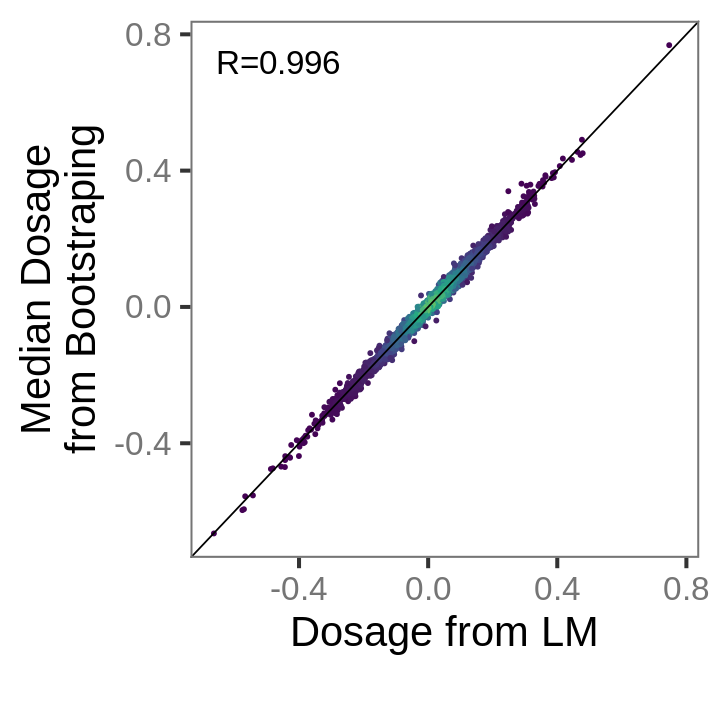

In [101]:
# pdf(file = '../Figures/CD45_LM_Bootstrap_Dosage_Median.pdf', width = 6, height = 6)
r = cor.test(all_res[['Dosage']], all_res[['Dosage_Bootstrap_50%']], method = 'pearson')$estimate
p = cor.test(all_res[['Dosage']], all_res[['Dosage_Bootstrap_50%']], method = 'pearson')$p.value

x = 'Dosage'
y = 'Dosage_Bootstrap_50%'
all_res$Density = 0
all_res[all_res[c(x, y)] %>% na.omit() %>% rownames, 'Density'] = get_density(na.omit(all_res[c(x, y)])[[x]], 
                              na.omit(all_res[c(x, y)])[[y]], n = 100)
vmax = max(all_res$Density)
print(vmax)

min = all_res[c('Dosage', 'Dosage_Bootstrap_50%')] %>% na.omit %>% min
max = all_res[c('Dosage', 'Dosage_Bootstrap_50%')] %>% na.omit %>% max

fig.size(6, 6)
p1 = ggplot(all_res[sample(rownames(all_res)), ], aes(x=`Dosage`, y =`Dosage_Bootstrap_50%`))+
    geom_point(aes(color = Density), size = 1)+
    # stat_density_2d(aes(fill = ..level..), geom = "polygon", alpha = 0.5) +
    # geom_point(aes(color = ..density..), stat = "density_2d", size = .2) +
    # scale_fill_viridis_c() +
    scale_color_viridis_c(
        limits = c(0, maxvmax), oob = scales::squish
    ) +

    theme_pres(base_size = 25)+
    geom_abline(slope = 1, intercept = 0)+
    annotate('text', x = min+0.2, y = max-0.05, label = paste0('R=', round(r, 3)), size = 7)+
    xlim(min, max)+
    ylim(min, max)+
    xlab('Dosage from LM\n')+
    ylab('Median Dosage\nfrom Bootstraping')+
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), legend.position="none")
p1
# dev.off()

[1] 70.39967


Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


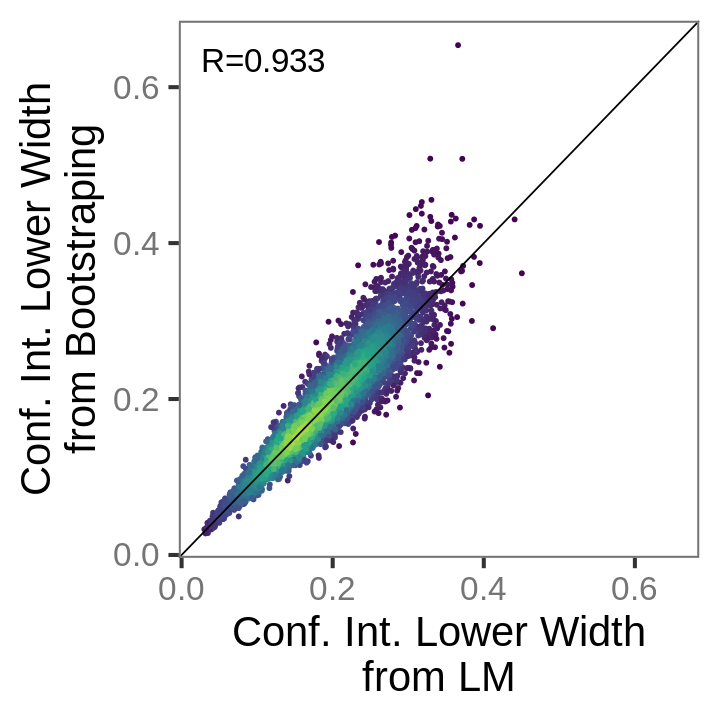

In [104]:
# pdf(file = '../Figures/CD45_LM_Bootstrap_Dosage_UpperLim.pdf', width = 6, height = 6)
r = cor.test(all_res[['Lower_Width']], all_res[['Lower_Width_Bootstrap']], method = 'pearson')$estimate
p = cor.test(all_res[['Lower_Width']], all_res[['Lower_Width_Bootstrap']], method = 'pearson')$p.value

min = all_res[c('Lower_Width', 'Lower_Width_Bootstrap')] %>% na.omit %>% min
max = all_res[c('Lower_Width', 'Lower_Width_Bootstrap')] %>% na.omit %>% max

x = 'Lower_Width'
y = 'Lower_Width_Bootstrap'
all_res$Density = 0
all_res[all_res[c(x, y)] %>% na.omit() %>% rownames, 'Density'] = get_density(na.omit(all_res[c(x, y)])[[x]], 
                              na.omit(all_res[c(x, y)])[[y]], n = 100)
vmax = max(all_res$Density)
print(vmax)

fig.size(6, 6)
p2 = ggplot(all_res[sample(rownames(all_res)), ])+
    geom_point(aes(x=`Lower_Width`, y =`Lower_Width_Bootstrap`, color = Density), size = 1)+
    scale_color_viridis_c(limits = c(0, maxvmax), oob = scales::squish) +
    theme_pres(base_size = 25)+
    geom_abline(slope = 1, intercept = 0)+
    annotate('text', x = min+0.08, y = max-0.02, label = paste0('R=', round(r, 3)), size = 7)+
    xlim(min, max)+
    ylim(min, max)+
    xlab('Conf. Int. Lower Width\nfrom LM')+
    ylab('Conf. Int. Lower Width\nfrom Bootstraping')+
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), legend.position="none")
p2
# dev.off()

In [70]:
all_res[sample(rownames(all_res)), ]

gene,(Intercept),log10(nUMI.y),PlateP3,PlateP4,Individual_Index10038222,Individual_Index10049338,Dosage,pval,Dosage_2.5%,⋯,padjBH,Dosage_Bootstrap_2.5%,Dosage_Bootstrap_50%,Dosage_Bootstrap_97.5%,StandardError_Bootstrap,Lower_Width,Upper_Width,Lower_Width_Bootstrap,Upper_Width_Bootstrap,Density
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ACBD6,-12.859493,3.130853,0.126184613,-0.11899018,0.1159325239,-0.3233276302,0.175492233,0.1124858921,-0.04059841,⋯,0.74570817,-0.01657566,0.183140207,0.330800649,0.006193814,0.21609064,0.21907051,0.19971586,0.14766044,13.159428
RP9,-9.935266,2.351737,-0.221589880,-0.30562099,0.3918705339,0.4748820448,0.034502596,0.7324406848,-0.16286063,⋯,0.96978664,-0.17501350,0.038428669,0.246257387,0.007656598,0.19736323,0.19891558,0.21344217,0.20782872,57.397803
PIM3,-6.085094,1.758198,0.082001082,0.01248568,0.0142689099,0.0698831417,-0.120049854,0.0694839840,-0.24863568,⋯,0.66648520,-0.24153376,-0.127239088,-0.008229373,0.004311145,0.12858583,0.12928513,0.11429467,0.11900971,20.507319
HINFP,-8.471327,1.724096,0.523714019,0.11299675,-0.0008782164,0.2634622734,0.136027826,0.3710959112,-0.16119337,⋯,0.87293388,-0.12903259,0.124013291,0.356831658,0.009782558,0.29722120,0.30142420,0.25304588,0.23281837,10.382588
XRN1,-8.246309,1.676914,-0.048599287,-0.30155583,0.4052439618,0.2462746471,0.024414849,0.8680967596,-0.26351600,⋯,0.98441122,-0.29582340,0.028509846,0.353770737,0.012101894,0.28793085,0.28963604,0.32433324,0.32526089,55.214533
DNAJC18,-8.245389,1.959046,-0.016673787,-0.18701979,-0.0552597366,-0.0003658455,-0.009090909,0.9211522033,-0.18863084,⋯,0.99018023,-0.22145284,-0.011495376,0.152985036,0.007208913,0.17953993,0.18010414,0.20995747,0.16448041,58.487149
C9orf78,-10.574574,2.593290,-0.001957524,0.04644095,-0.1922451599,-0.1215321052,-0.034840359,0.6894511590,-0.20564211,⋯,0.96023934,-0.18393354,-0.040023749,0.125915895,0.005930992,0.17080175,0.17116670,0.14390979,0.16593964,48.021338
DYNLRB1,-6.689574,1.635499,-0.457331151,-0.39177280,0.1375749472,0.0290252884,0.081705452,0.1907734832,-0.04063915,⋯,0.80396042,-0.03440198,0.085387734,0.206432480,0.004208025,0.12234460,0.12208218,0.11978972,0.12104475,39.950897
UBE2V2,-11.730338,2.802305,0.301132884,0.30328050,0.0990405830,0.1468560826,-0.033289467,0.6004411059,-0.15812755,⋯,0.93413210,-0.17001075,-0.047110371,0.087563959,0.004723361,0.12483808,0.12448462,0.12290038,0.13467433,41.129080


In [67]:
nrow(all_res)

[1] 5569

[1] 76.06256


Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


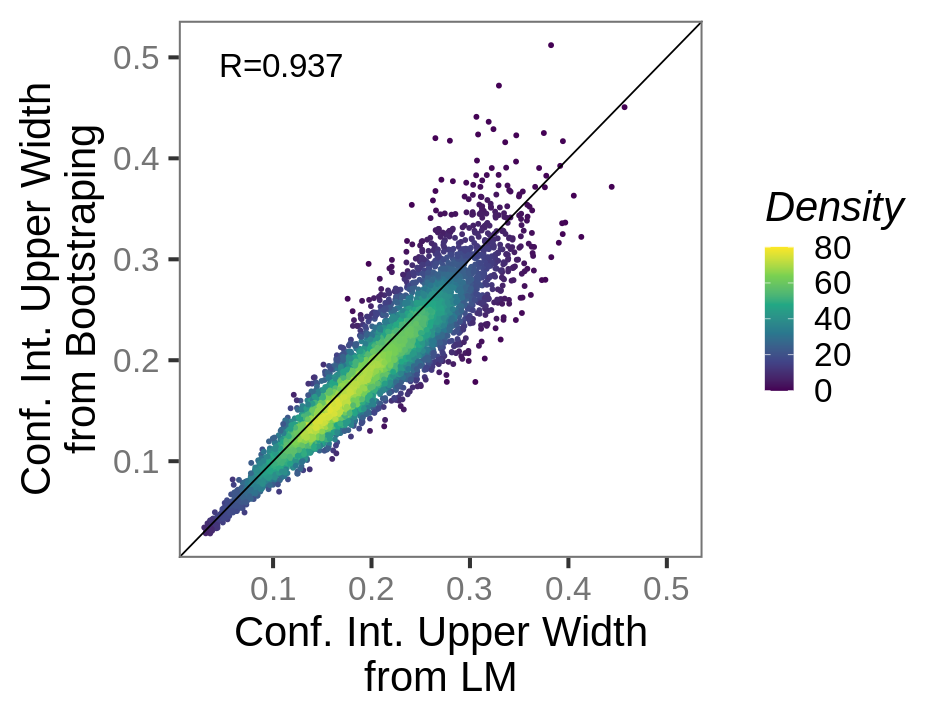

In [107]:
# pdf(file = '../Figures/CD45_LM_Bootstrap_Dosage_UpperLim.pdf', width = 6, height = 6)
r = cor.test(all_res[['Upper_Width']], all_res[['Upper_Width_Bootstrap']], method = 'pearson')$estimate
p = cor.test(all_res[['Upper_Width']], all_res[['Upper_Width_Bootstrap']], method = 'pearson')$p.value

min = all_res[c('Upper_Width', 'Upper_Width_Bootstrap')] %>% na.omit %>% min
max = all_res[c('Upper_Width', 'Upper_Width_Bootstrap')] %>% na.omit %>% max

x = 'Upper_Width'
y = 'Upper_Width_Bootstrap'
all_res$Density = 0
all_res[all_res[c(x, y)] %>% na.omit() %>% rownames, 'Density'] = get_density(na.omit(all_res[c(x, y)])[[x]], 
                              na.omit(all_res[c(x, y)])[[y]], n = 100)
vmax = max(all_res$Density)
print(vmax)

fig.size(6, 7.9)
p3 = ggplot(all_res[sample(rownames(all_res)), ])+
    geom_point(aes(x=`Upper_Width`, y =`Upper_Width_Bootstrap`, color = Density), size = 1)+
    scale_color_viridis_c(limits = c(0, maxvmax), oob = scales::squish) +
    theme_pres(base_size = 25)+
    geom_abline(slope = 1, intercept = 0)+
    annotate('text', x = min+0.08, y = max-0.02, label = paste0('R=', round(r, 3)), size = 7)+
    xlim(min, max)+
    ylim(min, max)+
    xlab('Conf. Int. Upper Width\nfrom LM')+
    ylab('Conf. Int. Upper Width\nfrom Bootstraping')+
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
p3
# dev.off()

In [108]:
library(gridExtra)
library(patchwork)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:gdata’:

    combine


The following object is masked from ‘package:dplyr’:

    combine




Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


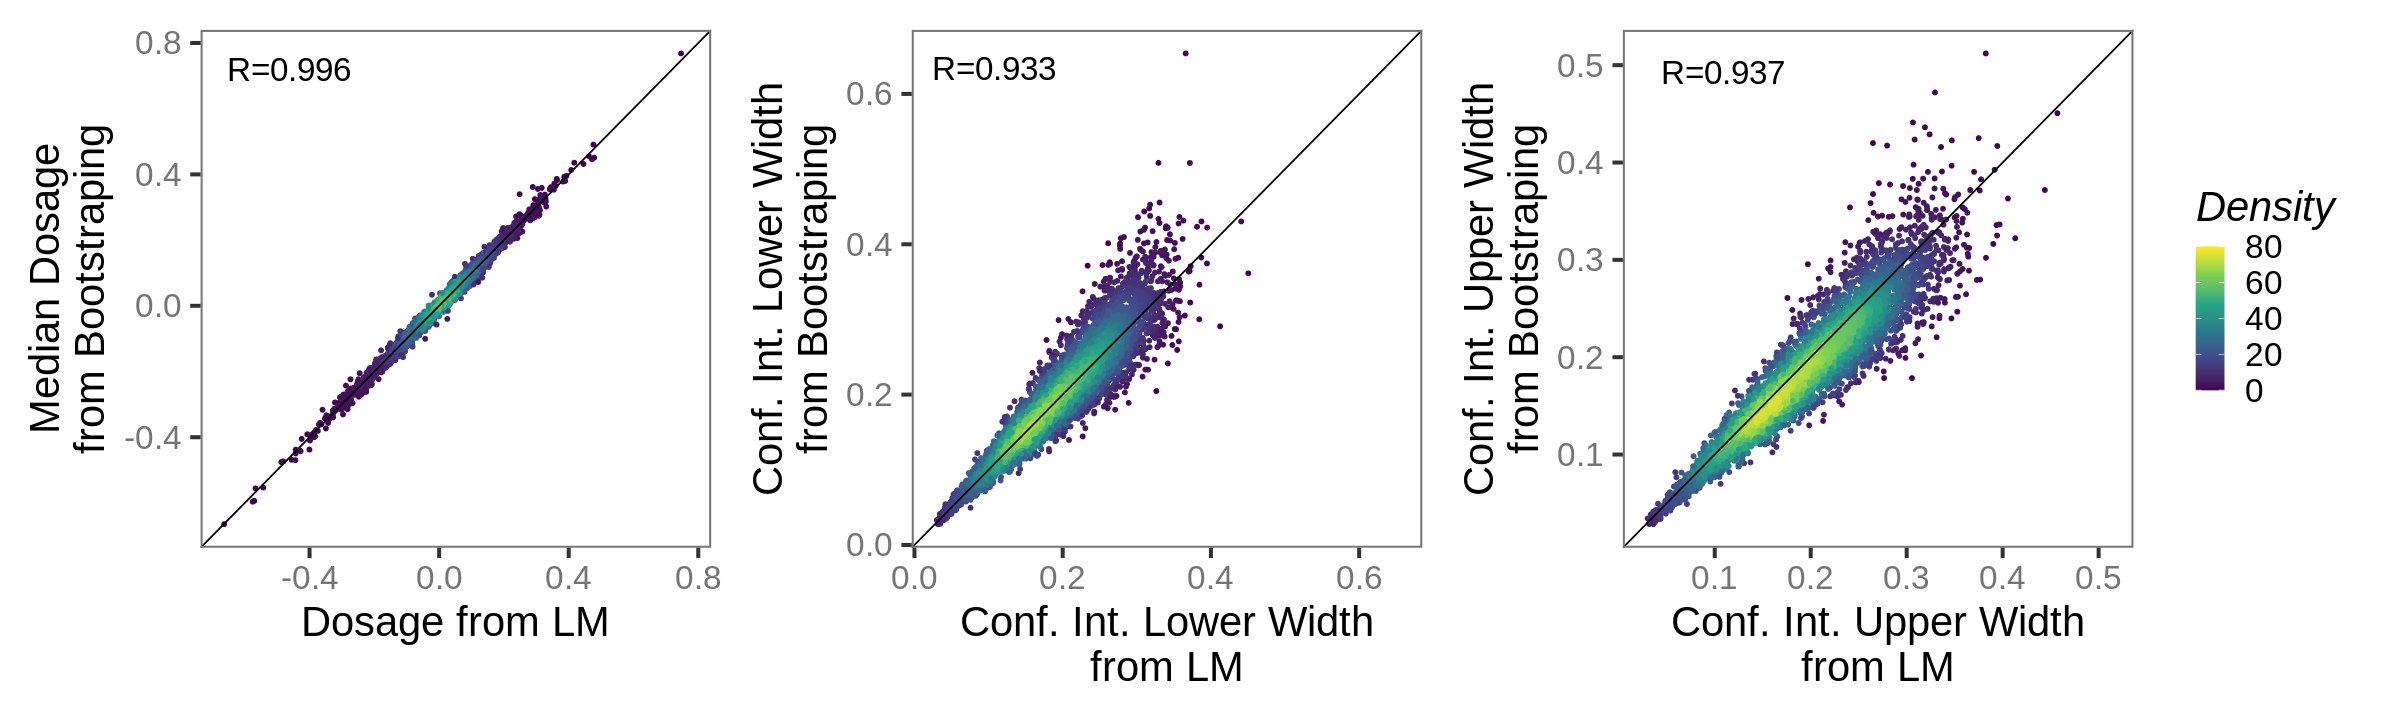

In [111]:
# pdf(file = '../Figures/CD45_LM_Bootstrap_Dosage_All.pdf', height = 6, width = 6*3)
fig.size(6, 6*2 + 7.9)
p1 + p2 + p3 + plot_layout(nrow = 1)
# dev.off()

In [112]:
all_res[['CI_Width']] = all_res[['Dosage_97.5%']] - all_res[['Dosage_2.5%']]
all_res[['CI_Width_Bootstrap']] = all_res[['Dosage_Bootstrap_97.5%']] - all_res[['Dosage_Bootstrap_2.5%']]

In [113]:
all_res %>% colnames

[1] "gene"                     "(Intercept)"             
 [3] "log10(nUMI.y)"            "PlateP3"                 
 [5] "PlateP4"                  "Individual_Index10038222"
 [7] "Individual_Index10049338" "Dosage"                  
 [9] "pval"                     "Dosage_2.5%"             
[11] "Dosage_97.5%"             "Std. Error"              
[13] "z value"                  "padjBH"                  
[15] "Dosage_Bootstrap_2.5%"    "Dosage_Bootstrap_50%"    
[17] "Dosage_Bootstrap_97.5%"   "StandardError_Bootstrap" 
[19] "Lower_Width"              "Upper_Width"             
[21] "Lower_Width_Bootstrap"    "Upper_Width_Bootstrap"   
[23] "Density"                  "CI_Width"                
[25] "CI_Width_Bootstrap"

In [114]:
library(eulerr)


In [142]:
install.packages("eulerr", repos='https://cran.wustl.edu/')

also installing the dependencies ‘GenSA’, ‘polylabelr’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



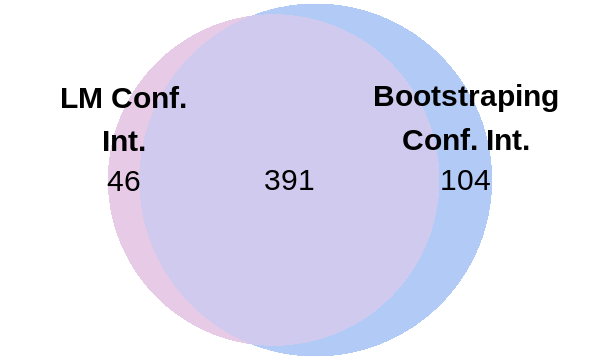

In [117]:
# pdf(file = '../Figures/CD45_LM_Bootstrap_NGenes.pdf',height = 3, width = 5)

# Define the sets
set1 <- (all_res %>% filter(pval < 0.05))[['gene']]
set2 <- (all_res %>% filter(`Dosage_Bootstrap_2.5%` > 0 | `Dosage_Bootstrap_97.5%` < 0))[['gene']]

# Create named lists of elements
sets <- list(
    `LM Conf.\nInt.` = set1,
    `Bootstraping\nConf. Int.` = set2
)

fit <- euler(sets)
fig.size(3, 5)
plot(
    fit,
    fills = c("plum3", "cornflowerblue"),  # Colors
    edges = NULL,
    labels = list(font = 2, family = "Arial", cex = 1.5),  # Customize fonts and sizes
    quantities = list(TRUE, cex = 1.5),
    alpha = 0.5
)

# dev.off()

# End

In [161]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /data/srlab1/mcurtis/miniforge3/envs/R4.1.1Py3.9.7/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] eulerr_7.0.2            future.apply_1.8.1      future_1.32.0          
 [4] dendsort_0.3.4          patchwork_1.3.0         magrittr_2.0.3         
 [7] irlba_2.3.5             uwot_0.2.2              harmony_0.1.0          
[10] Rcpp_1.0.8.3            Matrix_1.4-1            ph